In [1]:
setwd('/import/hd/')

In [3]:
library(monocle)
library(Seurat)

Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 4.2.3"
Loading required package: Biobase

Warning message:
"package 'Biobase' was built under R version 4.2.3"
Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages

In [2]:
sce = readRDS('./SCE.OA7.rds')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


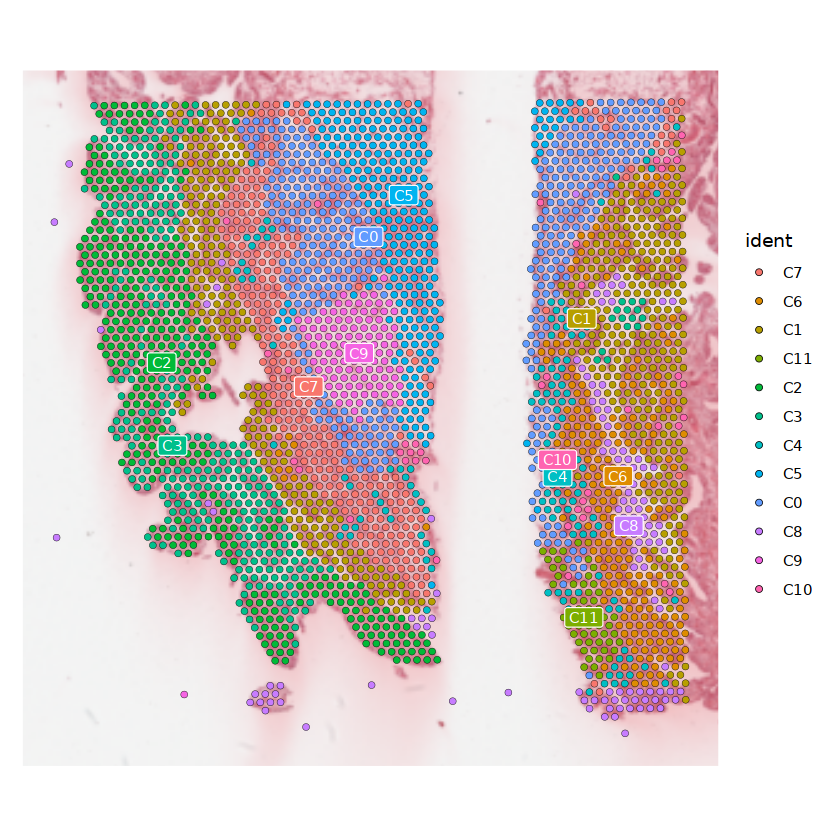

In [4]:
SpatialDimPlot(sce, label = TRUE, label.size = 3)

In [7]:
Idents(sce) = 'celltype'

In [9]:
subdata <- subset(sce, idents = c('C1','C2','C3','C7'))

In [10]:
expression_matrix = subdata@assays$Spatial@counts
cell_metadata <- data.frame(group = subdata[['orig.ident']],clusters = Idents(subdata))
gene_annotation <- data.frame(gene_short_name = rownames(expression_matrix), stringsAsFactors = F) 
rownames(gene_annotation) <- rownames(expression_matrix)

In [11]:
pd <- new("AnnotatedDataFrame", data = cell_metadata)
fd <- new("AnnotatedDataFrame", data = gene_annotation)
monocds <- newCellDataSet(expression_matrix,
                        phenoData = pd,
                        featureData = fd,
                        expressionFamily=negbinomial.size())


In [13]:
print("format data done , filter select genes ")
#pData(monocds)$Cluster<-as.factor(pData(monocds)$celltype) 
pData(monocds)['Cluster']=subdata@active.ident	
monocds <- estimateSizeFactors(monocds)
monocds <- estimateDispersions(monocds)

[1] "format data done , filter select genes "


Warning message:
"`group_by_()` was deprecated in dplyr 0.7.0.
i Please use `group_by()` instead.
i See vignette('programming') for more help
i The deprecated feature was likely used in the monocle package.
  Please report the issue to the authors."
Warning message:
"`select_()` was deprecated in dplyr 0.7.0.
i Please use `select()` instead.
i The deprecated feature was likely used in the monocle package.
  Please report the issue to the authors."
Removing 67 outliers

Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"
Warning message:
"step size truncated due to divergence"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: algorithm did not converge"


In [43]:
cds = monocds

### method1

In [44]:
# diff_test_res1 <- differentialGeneTest(cds,fullModelFormulaStr = '~clusters', cores = 40)
# #选择差异基因
# ordering_genes <- subset(diff_test_res1, qval < 0.05)[,'gene_short_name']
# #基因过滤
# cds <- setOrderingFilter(cds, ordering_genes)

### method2 

In [45]:
# cds <- detectGenes(cds, min_expr = 0.1)
# print(head(fData(cds)))
# expressed_genes <- row.names(subset(fData(cds), num_cells_expressed >= 30)) # nolint
# cds <- cds[expressed_genes, ]
# disp_table <- dispersionTable(cds)
# unsup_clustering_genes <- subset(
# disp_table, mean_expression >= 0.05 &
#   dispersion_empirical >= 1 * dispersion_fit
# ) #
# cds <- setOrderingFilter(cds, unsup_clustering_genes$gene_id)

### method3 可以保留

In [ ]:
# var.genes <- VariableFeatures(sce)
# cds <- setOrderingFilter(cds, var.genes)

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."


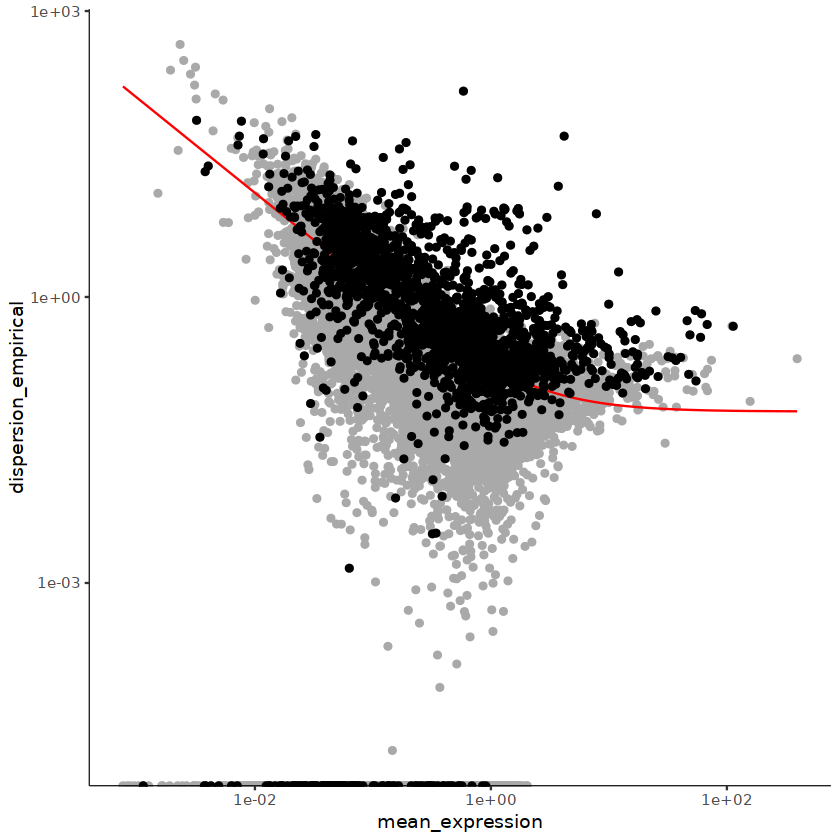

In [47]:
plot_ordering_genes(cds) 

In [48]:
cds <- reduceDimension(cds, max_components = 2,#residualModelFormulaStr = "~orig.ident", #去除样本影响
                       verbose = F, num_dim = 2, 
                       reduction_method = 'DDRTree')   # 修改method 为 reduction_method
cds <- orderCells(cds)

Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"
Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"


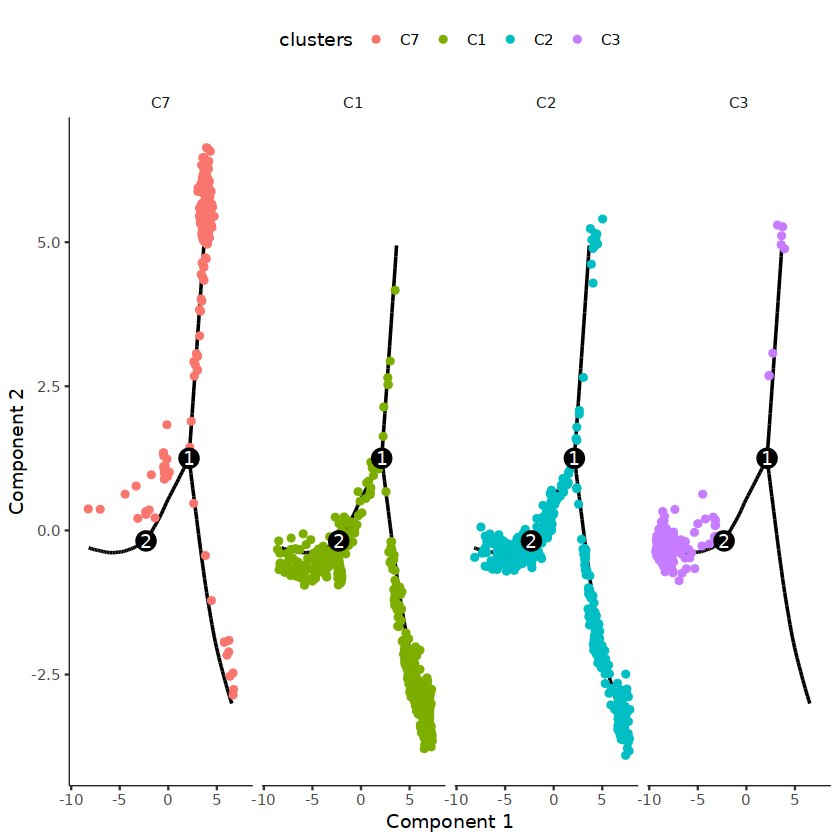

In [49]:
plot_cell_trajectory(cds, color_by = "clusters")+
  facet_wrap(~clusters, nrow = 1)

Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"
Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"


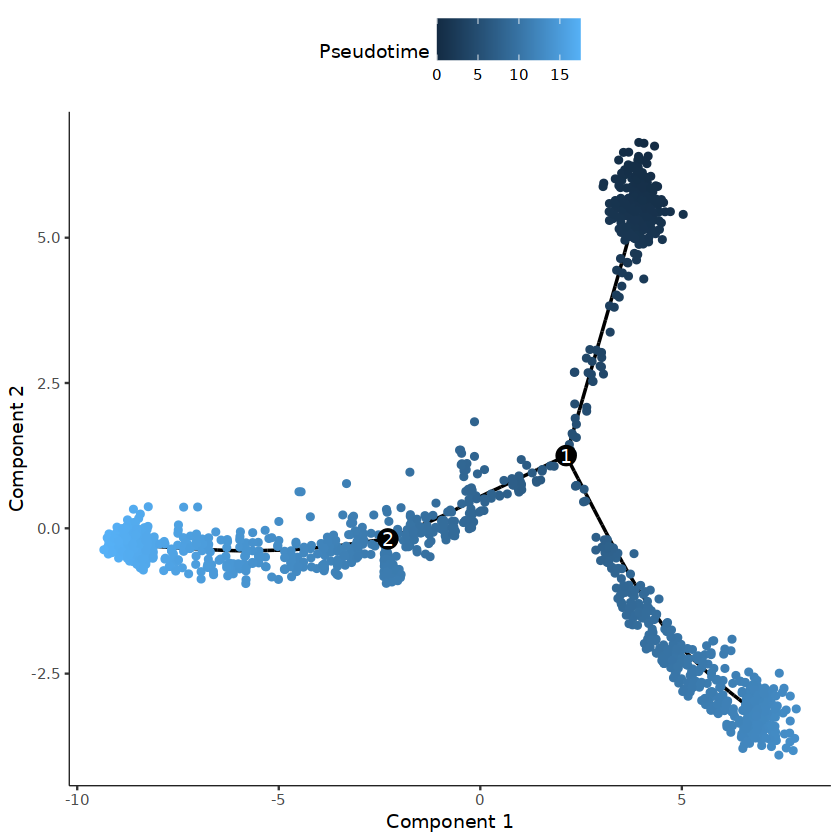

In [85]:
GM_state <- function(cds){
  if (length(unique(pData(cds)$State)) > 1){
    T0_counts <- table(pData(cds)$State, pData(cds)$clusters)[,"C7"]
    return(as.numeric(names(T0_counts)[which
                                       (T0_counts == max(T0_counts))]))
  } else {
    return (1)
  }
}
cds <- orderCells(cds, root_state = GM_state(cds))
plot_cell_trajectory(cds, color_by = "Pseudotime")

In [86]:
# cell_Pseudotime <- data.frame(pData(cds)$Pseudotime)
# rownames(cell_Pseudotime) <- rownames(cell_metadata)
#plot_cell_trajectory(cds, color_by = "Pseudotime",cell_size =0.5)

In [87]:
cell_Pseudotime <- data.frame(pData(cds)$Pseudotime)
rownames(cell_Pseudotime) <- rownames(cell_metadata)

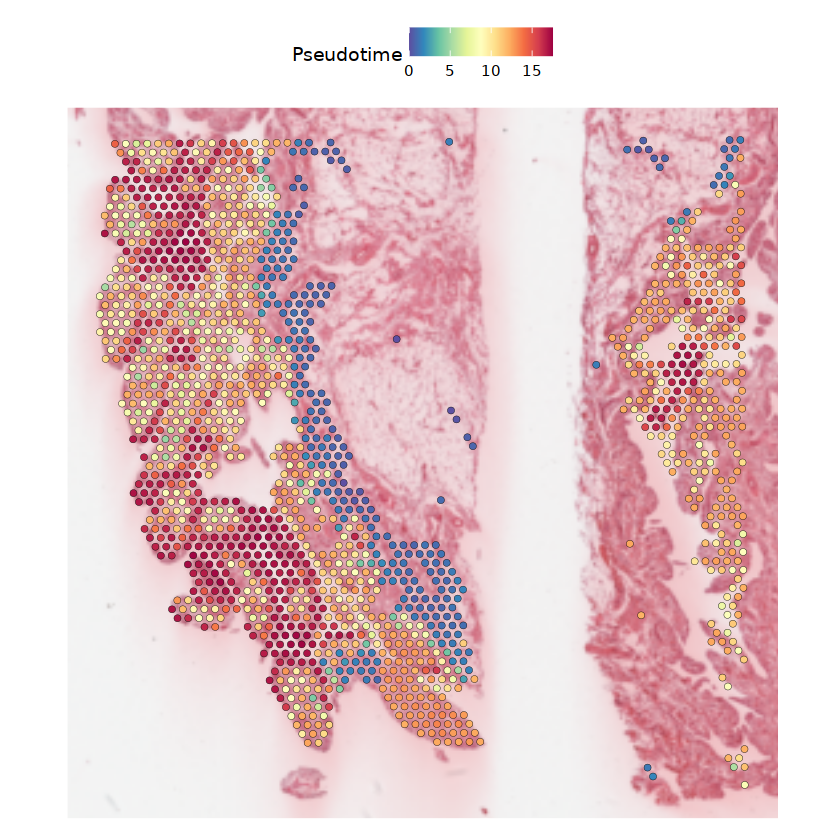

In [88]:
subdata[['Pseudotime']] <- 0
subdata[['Pseudotime']][rownames(cell_Pseudotime),] <- cell_Pseudotime
SpatialFeaturePlot(subdata, features = c("Pseudotime"),images='slice1')

In [59]:
Idents(subdata) = 'celltype'

In [60]:
table(subdata$celltype)


 C1  C2  C3  C7 
533 387 333 275 

In [61]:
library(CytoTRACE)

Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.


Warning message:
"The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application."


In [66]:
marrow_10x_expr  = as.matrix(subdata@assays$Spatial@counts)
marrow_10x_pheno <- subdata$celltype
marrow_10x_pheno = as.character(marrow_10x_pheno)
names(marrow_10x_pheno) <- rownames(subdata@meta.data)

In [67]:
results = CytoTRACE(marrow_10x_expr, 
	ncores = 35, subsamplesize = 1000)
length(results)  # 8

The number of cells in your dataset is less than 3,000. Fast mode has been disabled.

Warning message in CytoTRACE(marrow_10x_expr, ncores = 35, subsamplesize = 1000):
"27 genes have zero expression in the matrix and were filtered"
CytoTRACE will be run on 1 sub-sample(s) of approximately 1528 cells each using 1 / 35 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



[1] 8

Running t-SNE. To use your own coordinates, use the 'emb' flag.



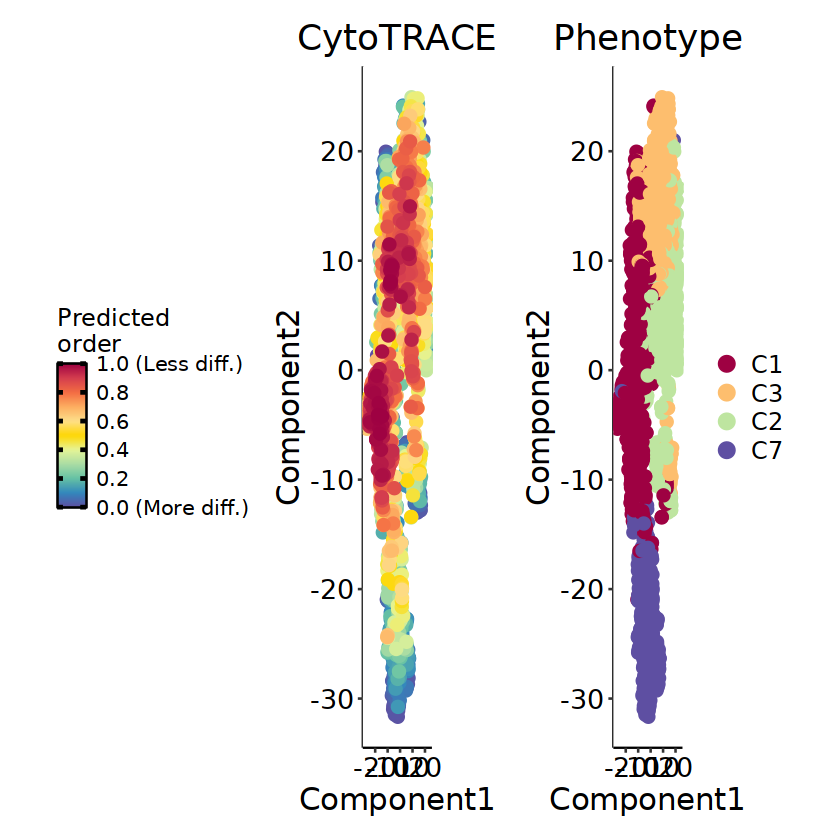

In [68]:
plotCytoTRACE(
	cyto_obj = results, 
	phenotype = marrow_10x_pheno, #细胞类型注释
	# gene = "Kit",  #是否映射特定基因表达
	emb = NULL,      #是否提供细胞降维坐标
	outputDir = "./" #图片储存路径
)

In [69]:
getwd()

[1] "/import/hd"

In [76]:
library(slingshot)
library(Seurat)
library(devtools)
library(cowplot)
library(ggplot2)
library(Matrix)
library(dplyr)
library(tradeSeq)
library(RColorBrewer)
library(DelayedMatrixStats)
library(scales)
library(paletteer) 
library(viridis)

Loading required package: princurve

Loading required package: TrajectoryUtils

Loading required package: SingleCellExperiment

Warning message:
"package 'SingleCellExperiment' was built under R version 4.2.2"
Loading required package: SummarizedExperiment

Warning message:
"package 'SummarizedExperiment' was built under R version 4.2.2"
Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.2.3"

Attaching package: 'matrixStats'


The following objects are masked from 'package:Biobase':

    anyMissing, rowMedians



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuan

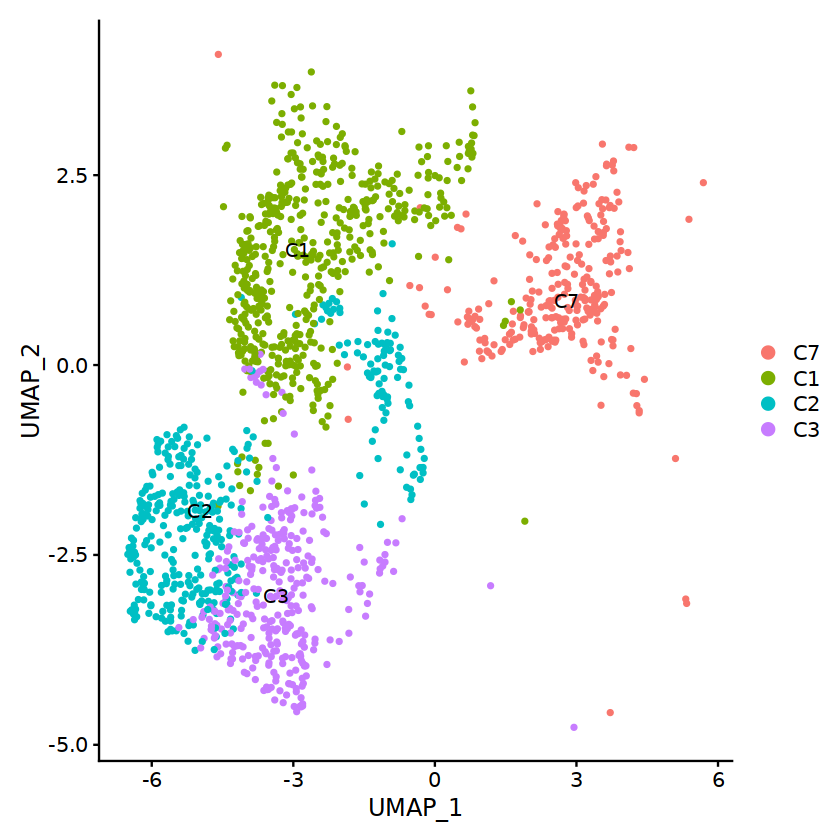

In [77]:
DimPlot(subdata,label = T)

In [78]:
sce1 = subdata

In [80]:
sce <- as.SingleCellExperiment(sce1, assay = "Spatial")

In [81]:
sce_slingshot1 <- slingshot(sce,      #输入单细胞对象
                     reducedDim = 'UMAP',  #降维方式
                     clusterLabels = sce$celltype,  #cell类型
                     #start.clus = 'BMSC',       #轨迹起点,也可以不定义
                     approx_points = 150)

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


In [82]:
SlingshotDataSet(sce_slingshot1) 

class: SlingshotDataSet 

 Samples Dimensions
    1528          2

lineages: 1 
Lineage1: C7  C1  C2  C3  

curves: 1 
Curve1: Length: 22.927	Samples: 1528

In [83]:
cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

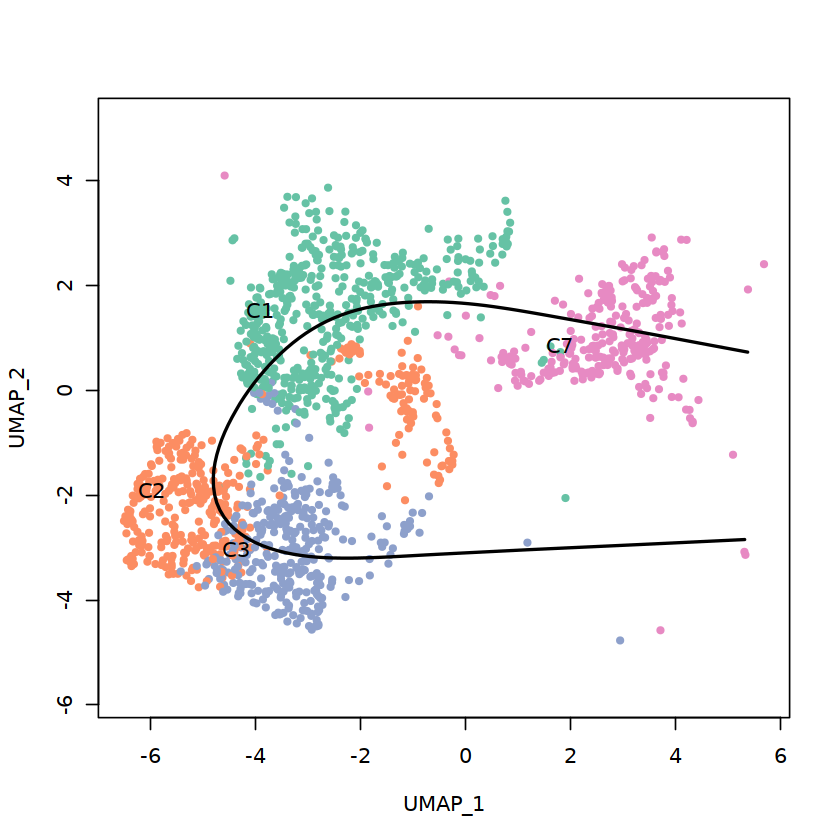

In [84]:
cell_colors <- cell_pal(sce_slingshot1$celltype, brewer_pal("qual", "Set2"))
plot(reducedDims(sce_slingshot1)$UMAP, col = cell_colors, pch=16, asp = 1, cex = 0.8)
lines(SlingshotDataSet(sce_slingshot1), lwd=2, col='black')

celltype_label <- sce1@reductions$umap@cell.embeddings%>% 
  as.data.frame() %>%
  cbind(celltype = sce1@meta.data$celltype) %>%
  group_by(celltype) %>%
  summarise(UMAP1 = median(UMAP_1),
            UMAP2 = median(UMAP_2))

for (i in 1:8) {
  text(celltype_label$celltype[i], x=celltype_label$UMAP1[i]-1, y=celltype_label$UMAP2[i])
}